# Import Data

In [4]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

labeledData = pd.read_csv(r'../Data/LabelData.csv')
UnlabeledData = pd.read_csv(r'../Data/UnlabelData.csv')
NormalizedData = labeledData
labeledData.head(1)


,user_id,age,male,friend_cnt,avg_friend_age,avg_friend_male,friend_country_cnt,subscriber_friend_cnt,songsListened,lovedTracks,...,delta_subscriber_friend_cnt,delta_songsListened,delta_lovedTracks,delta_posts,delta_playlists,delta_shouts,tenure,good_country,delta_good_country,adopter
0,10,24,0,20,26.333333,0.777778,6,0,37804,4,...,0,54,0,0,0,0,79,0,0,0


# Normalize Data

In [5]:
# Define continuous columns
continuous_columns = [
    "age", "friend_cnt", "avg_friend_age", "avg_friend_male", "friend_country_cnt",
    "subscriber_friend_cnt", "songsListened", "lovedTracks", "posts", "playlists", "shouts",
    "delta_friend_cnt", "delta_avg_friend_age", "delta_avg_friend_male", "delta_friend_country_cnt",
    "delta_subscriber_friend_cnt", "delta_songsListened", "delta_lovedTracks", "delta_posts", "delta_playlists", "delta_shouts", "tenure"
]

# Define preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('scaler', MinMaxScaler())
])

# Apply preprocessing pipeline to continuous variables
NormalizedData[continuous_columns] = preprocessing_pipeline.fit_transform(
    NormalizedData[continuous_columns])
NormalizedData.head(1)


,user_id,age,male,friend_cnt,avg_friend_age,avg_friend_male,friend_country_cnt,subscriber_friend_cnt,songsListened,lovedTracks,...,delta_subscriber_friend_cnt,delta_songsListened,delta_lovedTracks,delta_posts,delta_playlists,delta_shouts,tenure,good_country,delta_good_country,adopter
0,10,0.225352,0,0.002952,0.254902,0.777778,0.04918,0.0,0.040986,0.000071,...,0.424242,0.333894,0.016429,0.000079,0.2,0.181343,0.709091,0,0,0


# Feature Selection

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import keras_tuner
from tensorflow import keras
from keras_tuner.tuners import RandomSearch


In [11]:
# Load the data
X = labeledData.drop(['adopter', 'user_id'], axis=1)
y = labeledData['adopter']

# Perform feature selection using RFE
selector = RFE(estimator=RandomForestClassifier(), n_features_to_select=10, step=1)
selector = selector.fit(X, y)
selected_features = X.columns[selector.support_]

# Use the selected features
X_selected = X[selected_features]

print(selected_features)


Index(['age', 'friend_cnt', 'avg_friend_age', 'avg_friend_male',
       'songsListened', 'lovedTracks', 'shouts', 'delta_avg_friend_age',
       'delta_songsListened', 'tenure'],
      dtype='object')


# Neural Network(NN) Model

In [18]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create a Neural Network model
def create_model():
    Dropout_Rate = 0.65
    model = Sequential()
    model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(Dropout_Rate))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(Dropout_Rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(Dropout_Rate))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(Dropout_Rate))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer, metrics=['accuracy'])
    return model


# NN Random Oversampling

545/545 [==============================] - 0s 615us/step
Run 1: F1 Score: 0.09672131147540984
Restoring model weights from the end of the best epoch: 27.
Epoch 37: early stopping
545/545 [==============================] - 0s 633us/step
Run 2: F1 Score: 0.09846755787414412
Restoring model weights from the end of the best epoch: 34.
Epoch 44: early stopping
545/545 [==============================] - 0s 611us/step
Run 3: F1 Score: 0.09589993050729674
545/545 [==============================] - 0s 752us/step
Run 4: F1 Score: 0.08895265423242465
545/545 [==============================] - 0s 674us/step
Run 5: F1 Score: 0.09562943593574898
Average F1 Score: 0.09513417800500487


C:\Users\Marcu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


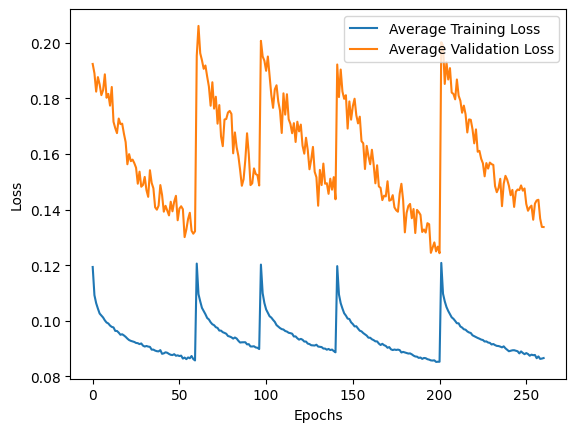

In [19]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, verbose=3, restore_best_weights=True)

f1_scores = []
training_losses = []
validation_losses = []

for i in range(5):
    # Apply RandomOverSampler to balance the training dataset
    ros = RandomOverSampler(random_state=42)
    X_train_balanced, y_train_balanced = ros.fit_resample(X_train, y_train)

    # Clone the model
    model_1 = create_model()

    # Train the model
    history = model_1.fit(X_train_balanced, y_train_balanced,
                          epochs=60, batch_size=128,
                          verbose=0, callbacks=[early_stopping],
                          validation_split=0.3)
    # Evaluate the model
    y_pred = (model_1.predict(X_test) > 0.5).astype(int)
    f1 = f1_score(y_test, y_pred)
    print(f"Run {i+1}: F1 Score: {f1}")
    training_losses.append(history.history['loss'])
    validation_losses.append(history.history['val_loss'])
    f1_scores.append(f1)

    if f1 < 0.085:
        print("Breaking the loop due to low F1 score.")
        break

average_f1 = np.mean(f1_scores)
print(f"Average F1 Score: {average_f1}")

# Calculate the average training and validation losses over all runs
avg_training_loss = np.mean(training_losses, axis=0)
avg_validation_loss = np.mean(validation_losses, axis=0)

# Plot the average training and validation losses
plt.plot(avg_training_loss, label='Average Training Loss')
plt.plot(avg_validation_loss, label='Average Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [20]:
# print(avg_training_loss, avg_validation_loss)
# Top record F1 Score: 0.10181818181818182
# Top Avg F1 Score: 0.09555316133087799
model_1.summary()


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_75 (Dense)            (None, 256)               2816      
                                                                 
 dropout_60 (Dropout)        (None, 256)               0         
                                                                 
 dense_76 (Dense)            (None, 128)               32896     
                                                                 
 dropout_61 (Dropout)        (None, 128)               0         
                                                                 
 dense_77 (Dense)            (None, 64)                8256      
                                                                 
 dropout_62 (Dropout)        (None, 64)                0         
                                                                 
 dense_78 (Dense)            (None, 32)              

### Improvement Ideas

- Introduce 5 Folds, Have the model split each fold 7:3, Train, then Test within each fold producing a F1 score, then ensemble the models from each fold to produce a "best model"
- Experiment with different architectures & hyperparameters

By messing with the architecture, specifically making the last later reduce nodes by /4 instead of /2, we were able to get results above .1, however the model was inconsistent. The current state, we are attempting to improve consistency to a margin of 0.002 and are slowly improving the F1 score of out models, typically by an increment of 0.01, per positive change. 

- Top record F1 Score: 0.10181818181818182
- Top Avg F1 Score: 0.09555316133087799
